KNN Analysis of May 2021 Divvy Data

In [2]:
# import packages
import pandas as pd
import sklearn.neighbors as NN
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import sklearn.metrics as metrics
import geopy.distance
import seaborn as sns
from matplotlib.colors import ListedColormap

In [3]:
# import data
input_data = pd.read_csv(r"C:\Users\HP\Documents\GitHub\CS-396-Divvy-Bikes\Data\202105-divvy-tripdata.csv")

Create Data For Distance and Duration

In [4]:
# takes two strings as inputs and outputs a datetime.timeDelta object
def subtractTime(startStr, endStr):
    startVec = re.split(r'\D+', startStr)
    endVec = re.split(r'\D+', endStr)
    for i in range(5):
        startVec[i] = int(startVec[i])
        endVec[i] = int(endVec[i])
    start = datetime.datetime(startVec[2], startVec[0], startVec[1], startVec[3], startVec[4])
    end = datetime.datetime(endVec[2], endVec[0], endVec[1], endVec[3], endVec[4])
    duration = end-start
    return duration

In [5]:
# takes two sets of latitude and longitude and outputs a distance in miles
def geoDistance(sLat, sLon, eLat, eLon):
    c1 = (sLat, sLon)
    c2 = (eLat, eLon)
    return geopy.distance.distance(c1, c2).miles

In [6]:
membership = input_data.loc[:, 'member_casual']
start_time = input_data.loc[:, 'started_at']
end_time = input_data.loc[:, 'ended_at']
start_lat = input_data.loc[:, 'start_lat']
start_lon = input_data.loc[:, 'start_lng']
end_lat = input_data.loc[:, 'end_lat']
end_lon = input_data.loc[:, 'end_lng']

duration = np.ndarray(membership.size)
distance = np.ndarray(membership.size)
for i in range(membership.size):
    # find the duration between the start and end of the ride
    dur = subtractTime(start_time[i], end_time[i])
    duration[i] = dur.days*24*60 + dur.seconds/60
    # find distance between the starting and ending stations
    distance[i] = geoDistance(start_lat[i], start_lon[i], end_lat[i], end_lon[i])

Create and test KNN model

In [7]:
# fit KNN model
X_train, X_test, y_train, y_test = train_test_split(np.column_stack([distance, duration]), membership, test_size = 0.20)
man_scores = []
euc_scores = []
max_k = 20
man_highestAcc = 0
man_highestK = 0
euc_highestAcc = 0
euc_highestK = 0
for k in range(1, max_k):
    # test using Manhattan distance
    model = NN.KNeighborsClassifier(n_neighbors = k, p = 1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test,y_pred)
    man_scores.append(accuracy)
    if accuracy > man_highestAcc:
        man_highestAcc = accuracy
        man_highestK = k

    # testing using Euclidian distance
    model = NN.KNeighborsClassifier(n_neighbors = k, p = 2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test,y_pred)
    euc_scores.append(accuracy)
    if accuracy > euc_highestAcc:
        euc_highestAcc = accuracy
        euc_highestK = k

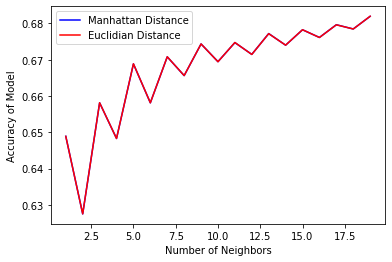

The highest accuracy of the model using Manhattan distance is: 0.681944675425467 at 19 neighbors.
The highest accuracy of the model using Euclidian distance is: 0.6819668496036365 at 19 neighbors.


In [8]:
fig, ax = plt.subplots()
plt.plot(range(1, max_k), man_scores, color='blue')
plt.plot(range(1, max_k), euc_scores, color='red')
ax.legend(["Manhattan Distance", "Euclidian Distance"])
ax.set_xlabel("Number of Neighbors")
ax.set_ylabel("Accuracy of Model")
plt.show()

print("The highest accuracy of the model using Manhattan distance is:", man_highestAcc, "at", man_highestK, "neighbors.")
print("The highest accuracy of the model using Euclidian distance is:", euc_highestAcc, "at", euc_highestK, "neighbors.")

In [9]:
members = 0
total = 0
for i in membership:
    if i == 'member':
        members+=1
    total+=1

print("If the computer guessed member everytime, it would have an accuracy of:", members/total)

If the computer guessed member everytime, it would have an accuracy of: 0.5192118357680743


In [10]:
# plotting the training testing data with classification
train_x_member = []
train_x_casual = []
test_x_member = []
test_x_casual = []
y_tr = y_train.values
y_te = y_test.values

for i in range(y_tr.size):
    if y_tr[i] == 'member':
        train_x_member.append(X_train[i])
    else:
        train_x_casual.append(X_train[i])

for i in range(y_te.size):
    if y_te[i] == 'member':
        test_x_member.append(X_test[i])
    else:
        test_x_casual.append(X_test[i])

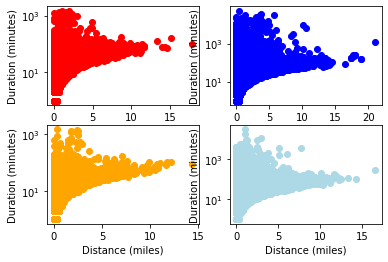

In [11]:
# plot 1
ax = plt.subplot(2, 2, 1)
ax.set_yscale('log')
plt.scatter(np.array(train_x_member)[:, 0], np.array(train_x_member)[:, 1], color = 'red')
ax.set_xlabel("Distance (miles)")
ax.set_ylabel("Duration (minutes)")

# plot 2
ax = plt.subplot(2, 2, 2)
ax.set_yscale('log')
plt.scatter(np.array(train_x_casual)[:, 0], np.array(train_x_casual)[:, 1], color = 'blue')
ax.set_xlabel("Distance (miles)")
ax.set_ylabel("Duration (minutes)")

# plot 3
ax = plt.subplot(2, 2, 3)
ax.set_yscale('log')
plt.scatter(np.array(test_x_member)[:, 0], np.array(test_x_member)[:, 1], color = 'orange')
ax.set_xlabel("Distance (miles)")
ax.set_ylabel("Duration (minutes)")

# plot 4
ax = plt.subplot(2, 2, 4)
ax.set_yscale('log')
plt.scatter(np.array(test_x_casual)[:, 0], np.array(test_x_casual)[:, 1], color = 'lightblue')
ax.set_xlabel("Distance (miles)")
ax.set_ylabel("Duration (minutes)")
plt.show()

Plotting decision boundary of most accurate model

In [29]:
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
np.arange(y_min, y_max, 1))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
Zbin = np.ndarray(Z.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        if Z[i][j] == 'casual':
            Zbin[i][j] = 1

(-1.0, 17.0)

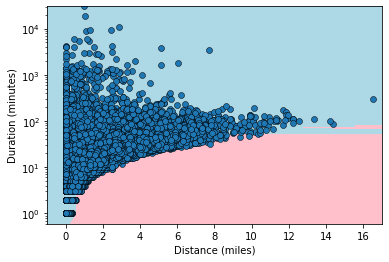

In [30]:
ax = plt.subplot()

cmap_light = ListedColormap(['pink', 'lightblue'])
cmap_bold = ['red','blue']

plt.contourf(xx, yy, Zbin, cmap=cmap_light)

sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1],
palette=cmap_bold, alpha=1.0, edgecolor="black")

ax.set_yscale('log')
ax.set_xlabel("Distance (miles)")
ax.set_ylabel("Duration (minutes)")
plt.xlim(xx.min(), xx.max())